In [1]:
import matplotlib.pyplot as plt
import json
from scipy import interpolate
import numpy as np
import matplotlib.pyplot as plt
import random
import os
import mmcv
import cv2
import pandas as pd

In [31]:
s='atee'
b='tea'
(6*8)%10, (6*8)//10


(8, 4)

In [57]:
class Solution:
    def fullJustify(self, words, maxWidth):
        
        
        output = []
        
        i=0
        j=0
        while i<len(words):
            curr_str = ''
            curr_words = []

            print(words[j])
            while j<len(words):
                if len(curr_str)+len(words[j])<=maxWidth:
                    curr_str += words[j] + ' '
                    curr_words.append(words[j])
                    j += 1
                else:

                    print(curr_words)
                    output.append(self.fillSpaces(curr_words, maxWidth))
                    break
                    
            i = j

            
        output.append(self.fillSpaces(curr_words, maxWidth, True))
        return output
            
            
    def fillSpaces(self, words, maxWidth, is_last=False):
        
        if is_last or len(words)==1:
            spaces = ' '*(maxWidth - sum([len(w)+1 for w in words])+1)
            print(len(spaces))
            return ' '.join(words) + ' '*(maxWidth - sum([len(w)+1 for w in words])+1)
            
        
        numInterv = len(words) - 1
        numSpaces = maxWidth - sum([len(w) for w in words])
        
        size = numSpaces / numInterv
        
        if numSpaces%numInterv==0:
            return (' '*int(size)).join(words)
        else:
            firstSpace = numSpaces - int(size)*(numInterv-1)
            return ' '*firstSpace.join([words[0], words[1]]) + ' '*int(size) + (' '*int(size)).join(words[2:])
            
            
            
s = Solution()
s.fullJustify(["This", "is", "an", "example", "of", "text", "justification."], 16)

This
['This', 'is', 'an']
example
['example', 'of', 'text']
justification.
2


['This    is    an', 'example of text', 'justification.  ']

['This', 'is', 'an']
['example', 'of', 'text']


['This    is    an', 'example of text', '               ']

In [2]:
def post_process_ocr(data, thresh=5):
    print("Post processing of ocr missing intervals ...")
    i = 0
    j = 0
    gaps = []
    new_gap = False
    for en in range(len(data['results'])):
        if data['results'][str(en)]['score_bug_present'] and data['results'][str(en)]['game_clock_running'] and new_gap:
            gaps.append((j - i, (i, j)))
            new_gap = False
            j += 1
            i = j

        elif data['results'][str(en)]['score_bug_present'] and data['results'][str(en)]['game_clock_running'] and not new_gap:
            j += 1
            i = j

        else:
            j += 1
            new_gap = True

    for gap in gaps:
        if gap[0] <= thresh:
            for idx in range(gap[1][0], gap[1][1]):
                data['results'][str(idx)]['score_bug_present'] = True
                data['results'][str(idx)]['game_clock_running'] = True


    return data

In [3]:
game_name = '2020_11_28_TexasSouthern_at_OklahomaState'

trail_path = os.path.join('./demos/custom_5vals_colors_all_30ep_data2_50ep/', game_name, game_name + '_trails.json')
trails = json.load(open(trail_path))

ocr_path = os.path.join('/home/ubuntu/oljike/data/demo_vids/', game_name, game_name + '_ocr.json')
ocr = json.load(open(ocr_path))
# ocr = post_process_ocr(ocr, 5)

video_path = os.path.join('/home/ubuntu/oljike/data/demo_vids/', game_name, game_name + '.mp4')
video = mmcv.VideoReader(video_path)

csv_path = os.path.join('./demos/custom_5vals_colors_all_30ep_data2_50ep/', game_name, game_name + '_time.csv')
pl_time = pd.read_csv(csv_path)

In [4]:
for k in trails:
    if len(trails[k]['home'])>0:
        side='home'
    else:
        side='away'

In [5]:
player_time = int(pl_time[pl_time['jersey_number']==2][pl_time['team']=='Oklahoma State']['minutes_int'])
player_frames = (player_time*60) * video.fps
print("Number of frames the player played ", player_frames)

Number of frames the player played  48600.0


/home/ubuntu/anaconda3/envs/open-mmlab/lib/python3.7/site-packages/ipykernel_launcher.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """Entry point for launching an IPython kernel.


### Detecting breaks inside game moment

In [214]:
### To detect the break inside a game, when the game_clock_running=True, we need to get all such intervals, 
### and check if we have some trails inside them. However, we need to remember that a player is not always seen
### on the cameras. That's why we need to interpolate only the inner regions. 

### The question is how to do it? And why we need it?

In [6]:
game_frames = set()
for k in ocr['results']:
    if ocr['results'][k]['score_bug_present'] and ocr['results'][k]['game_clock_running']:
        game_frames.add(k)
print('The number of all game frames ', len(game_frames))

The number of all game frames  67997


In [7]:
### Let's take the ocr results and divide each frame into game interval.
def get_game_intervals(ocr):
    
    i,j = 0, 0
    intervals = []
    for k in ocr['results']:
        if (not ocr['results'][k]['score_bug_present'] or not ocr['results'][k]['game_clock_running']) and i==j:
            j += 1
            i = j
            
        elif (not ocr['results'][k]['score_bug_present'] or not ocr['results'][k]['game_clock_running']) and i!=j:
            intervals.append((i,j))
            i = j
        elif ocr['results'][k]['score_bug_present'] and ocr['results'][k]['game_clock_running']:
            j += 1
            
    return intervals     
game_intervals = get_game_intervals(ocr)

In [8]:
print("Number of game intervals ", len(game_intervals))
print('Number of game frames ', sum([x[1]-x[0] for x in game_intervals]))

Number of game intervals  358
Number of game frames  67997


In [9]:
### Visualise game interval
### Visualise video to check the interval
def vis_interval(video, game_interval):
    
    max_ = game_interval[1]
    min_ = game_interval[0]

    out = cv2.VideoWriter('test.mp4', cv2.VideoWriter_fourcc(*'MP4V'), video.fps, (video.width, video.height))
    
    for en in range(min_, max_):
        frame = video.get_frame(en)
        out.write(frame)
        
    out.release()    
vis_interval(video, game_intervals[168])

KeyboardInterrupt: 

In [218]:
### now, when we have the game intervals, we can iterate through the trails and divide them into seperate 
### game intervals. Then we will check each sepearte interval for:
### 1. Outliers 2. Breaks. 3 etc.

In [10]:
trails_sorted = {k: trails[k] for k in sorted(trails)}

In [11]:
def get_trail_interval(trails, game_intervals):
    intr_dict = {}
    miss = set()
    for en, k in enumerate(trails):
        for int_en, intr in enumerate(game_intervals):   
            if intr[0]<=int(k)<=intr[1]:
                if int_en not in intr_dict:
                    intr_dict[int_en] = [k]
                else: 
                    intr_dict[int_en].append(k)
                break
            else:
                miss.add(int(k))
     
    print('The number of frames in the game intervals ', sum([len(intr_dict[k]) for k in intr_dict]))
    print("The number of tracked frames", len(trails))
    print("The number of non-game-interval tracks", len(trails) - sum([len(intr_dict[k]) for k in intr_dict]))   


    return intr_dict, miss
    
intr_dict, miss = get_trail_interval(trails_sorted, game_intervals)

The number of frames in the game intervals  29961
The number of tracked frames 32835
The number of non-game-interval tracks 2874


In [12]:
### Now, when we have the correspondence between the game frames and the tracked frames, we can take each tracked
### interval seperately and process it for :
### 1. Outliers 2. Breaks 3. Etc...

In [13]:
def get_seperate_track_intervals(intr_dict, trails):
    intr_dict_sorted = {k: intr_dict[k] for k in sorted(intr_dict)}
    
    separate_tracked_intervals = []
    for intr_en in intr_dict_sorted:
        curr_tracked_interval = {}
        for frame in intr_dict_sorted[intr_en]:
            curr_tracked_interval[frame] = trails[frame]
            
        separate_tracked_intervals.append(curr_tracked_interval)
        
    return separate_tracked_intervals
        
separate_tracked_intervals = get_seperate_track_intervals(intr_dict, trails)

print("Number of separete intervals for our player is ", len(separate_tracked_intervals))

Number of separete intervals for our player is  67


# Interpolation, outliers and visualisation

In [14]:
### Now, let's take a track one by one and visalise with and without interpolation

In [15]:
def calc_intervals(frames):
    
    cnt = 0
    i,j = 0, 1
    miss_len = [0]
    while j<len(frames):
        if frames[j] - frames[i] == 1:
            j += 1
            i += 1           
        else:
            miss_len.append(frames[j] - frames[i])
            cnt += 1
            j += 1
            i += 1
            
    return cnt + 1, miss_len  

def get_coords_for_track(single_track):
    
    
    x, y = [], []
    max_ = int(max(single_track, key=int))
    min_ = int(min(single_track, key=int))
    missed_frame = []
    for en in range(min_, max_+1):
        k = str(en)
        if k in single_track:
            if len(single_track[k]['home'])>0:
                x.append(single_track[k]['home']['2']['trail'][0])
                y.append(single_track[k]['home']['2']['trail'][2])
            else:
                x.append(single_track[k]['away']['2']['trail'][0])
                y.append(single_track[k]['away']['2']['trail'][2])
        else:
            missed_frame.append(en)
            x.append(x[-1])
            y.append(y[-1])
        

    diff = []
    outliers = []
    for en in range(1, len(x)):
        x2 = x[en]
        x1 = x[en-1]
        y2 = y[en]
        y1 = y[en - 1 ]
        dist = ((((x2 - x1 )**2) + ((y2-y1)**2) )**0.5)
        if dist>10:
            outliers.append(en)
        diff.append(dist)
        
    num_int, miss_len = calc_intervals(missed_frame)
    
    if len(diff)>0:
        print("Avg distance", sum(diff)/len(diff))
    print('Number of outliers ', len(outliers)) 
    print('Number of missed frames ', len(missed_frame)) 
    print('Number of seperate intervals ', num_int) 
    print('Length of max break ', max(miss_len)) 
    print("Length of the interval ", max_ - min_)
    print("-"*50)
    
    return x,y, outliers

### Interpolation

In [254]:
def interpolate_interval(single_track, side=None):
    
    x, y = [], []
    max_ = int(max(single_track, key=int))
    min_ = int(min(single_track, key=int))
    missed_frame = []
    
    is_open = False
    intervals_to_interpolate = []
    start = None
    for en in range(min_, max_+1):
        k = str(en)

        if k in single_track and is_open:
            intervals_to_interpolate.append((start, k))
            is_open = False
        elif k not in single_track and not is_open:
            start = str(int(k) - 1)
            is_open = True
            
            
    for intr in intervals_to_interpolate:
        if int(intr[1]) - int(intr[0]) < 10:
            
            x_len = abs(single_track[intr[1]][side]['2']['trail'][0] - single_track[intr[0]][side]['2']['trail'][0])
            y_len = abs(single_track[intr[1]][side]['2']['trail'][2] - single_track[intr[0]][side]['2']['trail'][2])
            
            x_step = x_len / (int(intr[1]) - int(intr[0]))
            y_step = y_len / (int(intr[1]) - int(intr[0])) 
            
            x = single_track[intr[0]][side]['2']['trail'][0]
            y = single_track[intr[0]][side]['2']['trail'][2]
            for k in range(int(intr[0])+1, int(intr[1])):
                x += x_step
                y += y_step
                single_track[str(k)] = {'home':  {'2': {'trail': [x,0,y,0]}}}
        
        
        
    return single_track


# interpolate_interval({'1':0, '2':0, '5':0, '6':0, '10':0})
xx=interpolate_interval(separate_tracked_intervals[interval_id], side)

### Visualisation

Avg distance 2.5842478451407636
Number of outliers  14
Number of missed frames  424
Number of seperate intervals  12
Length of max break  401
Length of the interval  1457
--------------------------------------------------


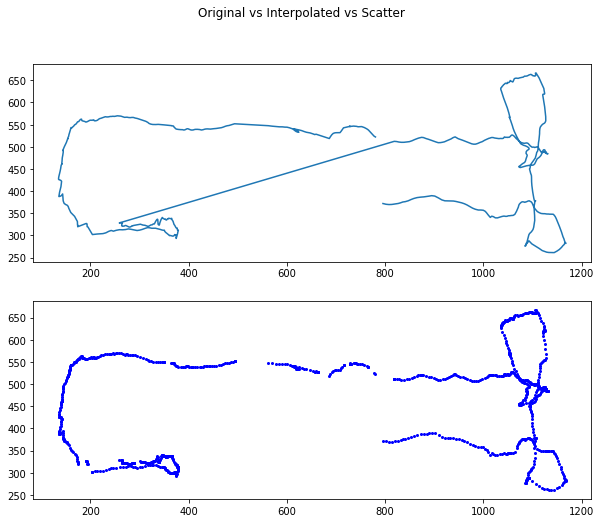

In [16]:
# for interval_id in range(len(separate_tracked_intervals)):
#     print(interval_id)
#     x, y, outliers = get_coords_for_track(separate_tracked_intervals[interval_id])

interval_id = 57
x, y, outliers = get_coords_for_track(separate_tracked_intervals[interval_id])
# x, y, outliers = get_coords_for_track(xx)



def B_spline(x,y, s=0.1, k=2):
    
        
    tck, *rest = interpolate.splprep([x,y], s=s, k=k)
    u = np.linspace(0, 1, num=100)
    smooth = interpolate.splev(u, tck)
    
    
    x_s, y_s = [], []
    for pt in zip(smooth[0], smooth[1]):
        x_s.append(pt[0])
        y_s.append(pt[1])

    return x_s, y_s

fig, (ax1, ax2) = plt.subplots(2)
fig.suptitle('Original vs Interpolated vs Scatter ')
fig.set_size_inches(10,8)

ax1.plot(x, y)
ax2.plot(x, y, 'bo', markersize=2,)

In [268]:
### Visualise video to check the interval
def vis_interval(video, single_track):
    
    x, y = [], []
    max_ = int(max(single_track, key=int))
    min_ = int(min(single_track, key=int))
    print("the first is {} and the last frame {}".format(min_, max_))
 
    color = (255,0,0)
    img_h = video.height
    img_w = video.width
    out = cv2.VideoWriter('test.mp4', cv2.VideoWriter_fourcc(*'MP4V'), video.fps, (video.width, video.height))
    
    court = np.ones((720, 1280, 3))*255
    court_w = 300
    court_h = 150
    for en in range(min_, max_):
        frame = video.get_frame(en)
        
        k = str(en)
        if k in single_track:
            if len(single_track[k]['home'])>0:
                bbox = single_track[k]['home']['2']['box']
                trail = single_track[k]['home']['2']['trail']
            else:
                bbox = single_track[k]['away']['2']['box']
                trail = single_track[k]['away']['2']['trail']
                
            bbox = np.array(bbox).astype(np.int)
            
            frame = cv2.rectangle(frame, (bbox[0], bbox[1]), (bbox[0]+bbox[2], bbox[1]+bbox[3]), color=color, thickness=1)
            court = cv2.circle(court, (int(trail[0]), int(trail[2])), 3, color)
            court_res = cv2.resize(court, (court_w, court_h))
            frame[:court_h, img_w-court_w:, :] = court_res
        
        else: 
            court_res = cv2.resize(court, (court_w, court_h))
            frame[:court_h, img_w-court_w:, :] = court_res


        
        out.write(frame)
        
    out.release()    
vis_interval(video, separate_tracked_intervals[interval_id])

the first is 142136 and the last frame 143593


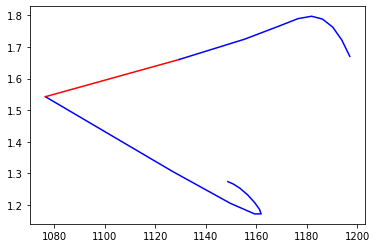

In [14]:
def plot_outliers(x, y, en):
    plt.plot(x[en-10:en+1], y[en-10:en+1],  c='blue', )
    plt.plot(x[en:en+2], y[en:en+2], c='red')
    plt.plot(x[en+1:en+10], y[en+1:en+10], c='blue')    
plot_outliers(x, y, outliers[2])

KeyboardInterrupt: 

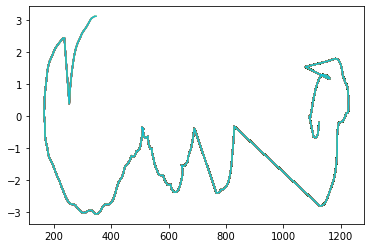

In [282]:
%matplotlib inline
import time
import pylab as pl
from IPython import display
for i in range(len(x)):
    pl.plot(x[:i],y[:i])
    display.clear_output(wait=True)
    display.display(pl.gcf())
    time.sleep(0.01)